# Explainable AI Predicts Customer Donation Behavior

Reference: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [16]:
import pandas as pd
import shap
import sklearn
import matplotlib.pyplot as plt
import xgboost

print(
    "shap ==",shap.__version__,
    "sklearn ==",sklearn.__version__,
    "xgboost ==",xgboost.__version__
)

shap == 0.41.0 sklearn == 1.0.2 xgboost == 1.7.1


In [17]:
path = 'donation_prediction/Customer_Analytics_TrainTest.csv'
data = pd.read_csv(path)
data.info()
# data['PRICE'].describe()

count    108.000000
mean      97.992259
std       26.429529
min       59.000000
25%       79.300001
50%       92.469501
75%      112.225000
max      195.000000
Name: PRICE, dtype: float64

In [18]:
X = data.drop(['PRICE'],axis=1)
cols = list(data.drop(['PRICE'],axis=1).columns)

feature_names = list(cols)
y = data['PRICE'].to_numpy()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


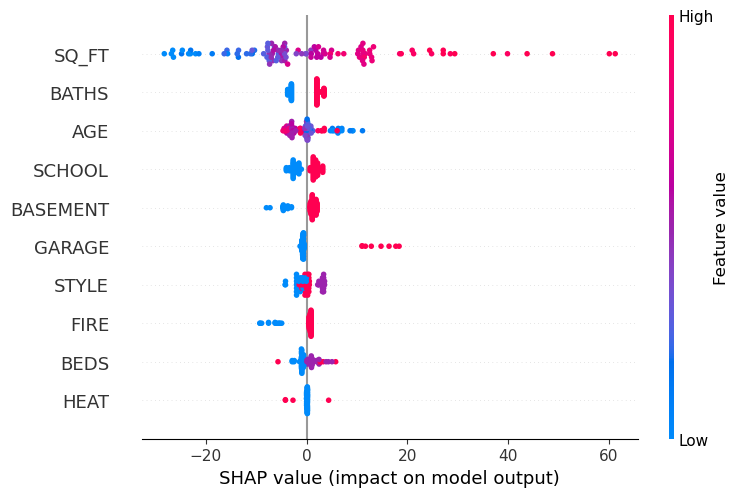

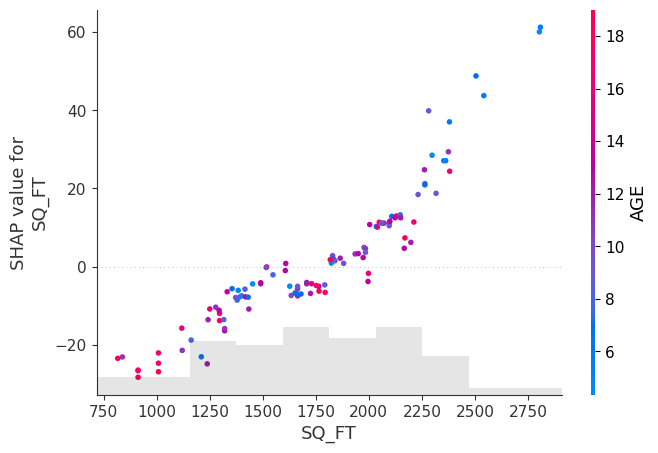

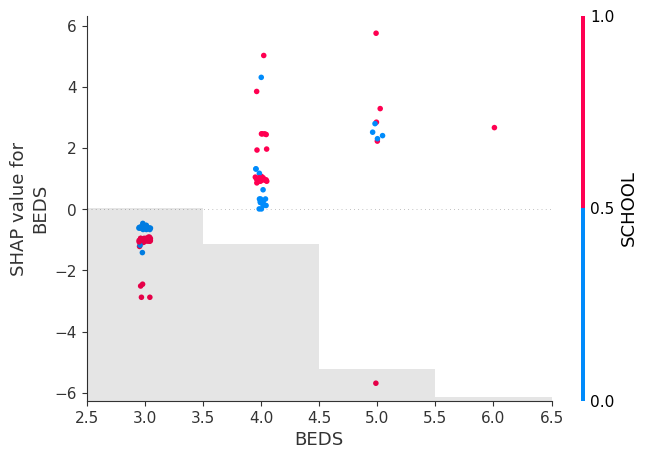

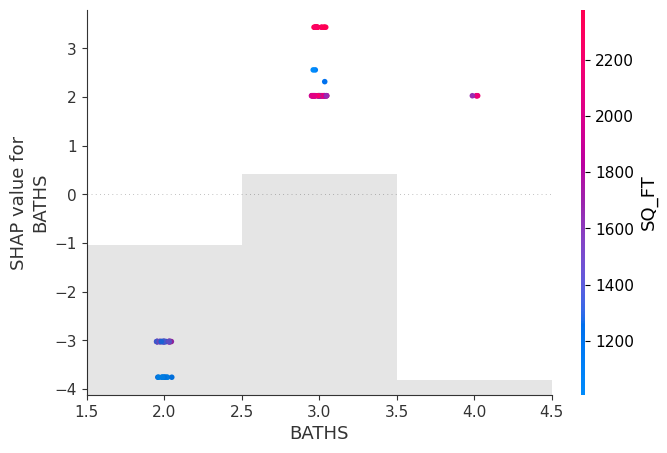

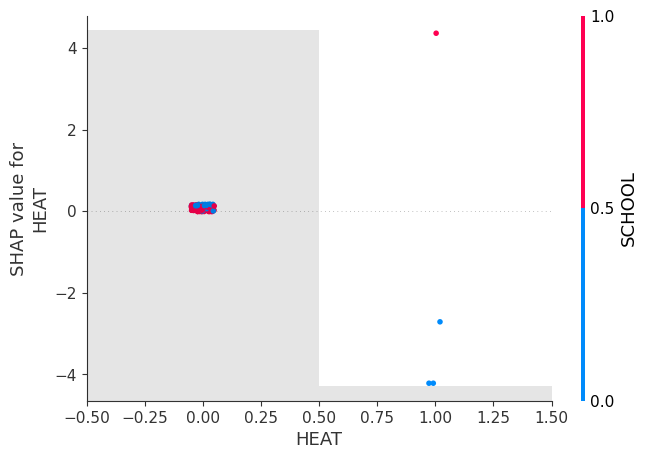

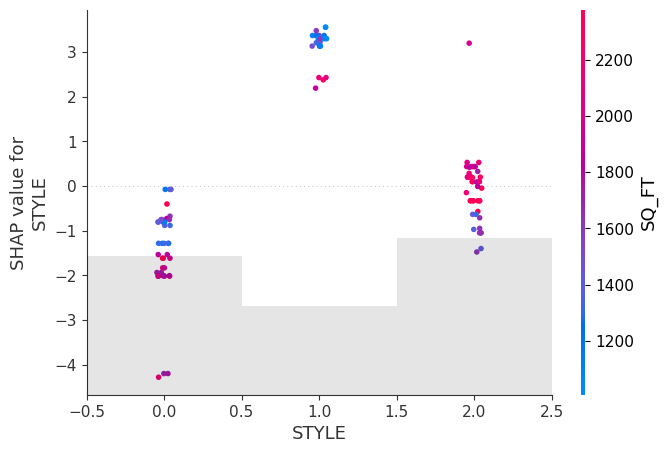

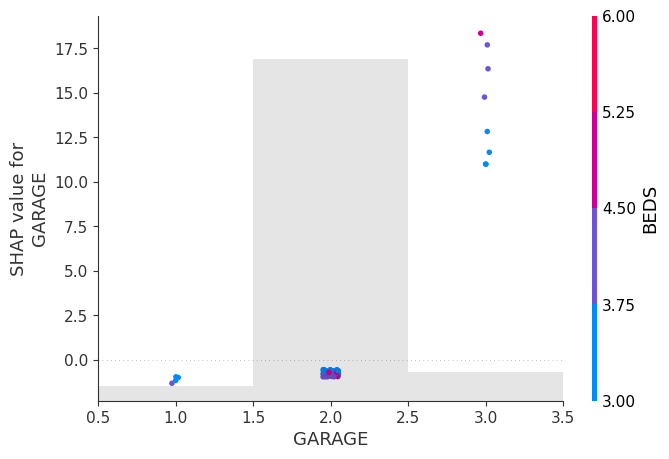

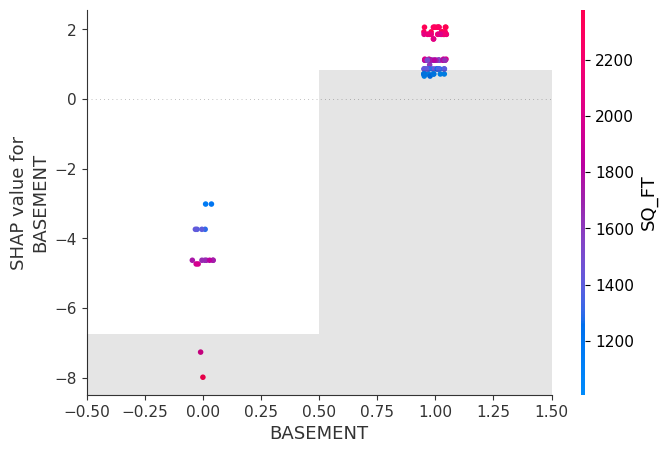

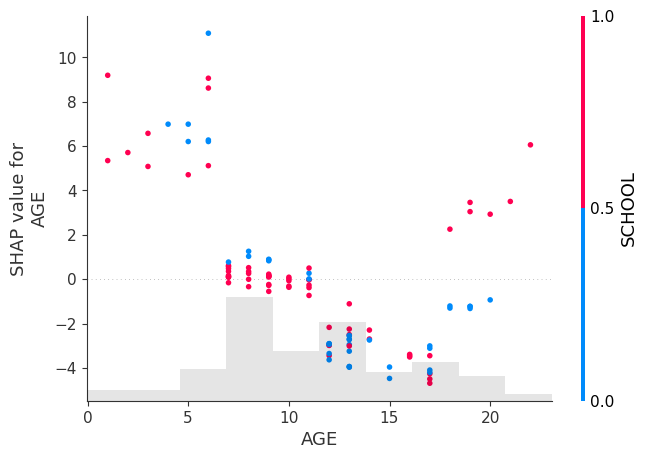

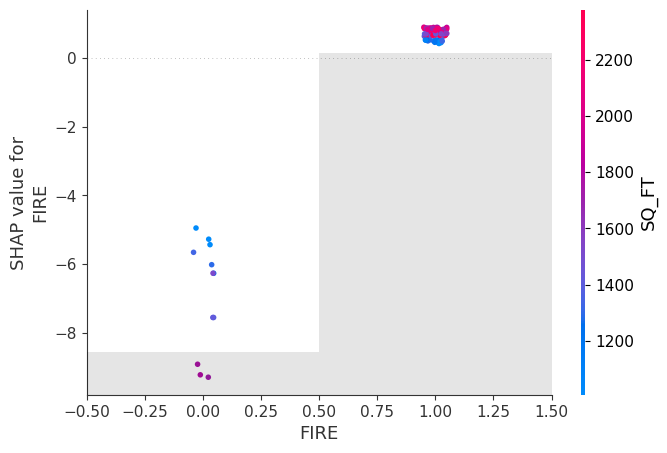

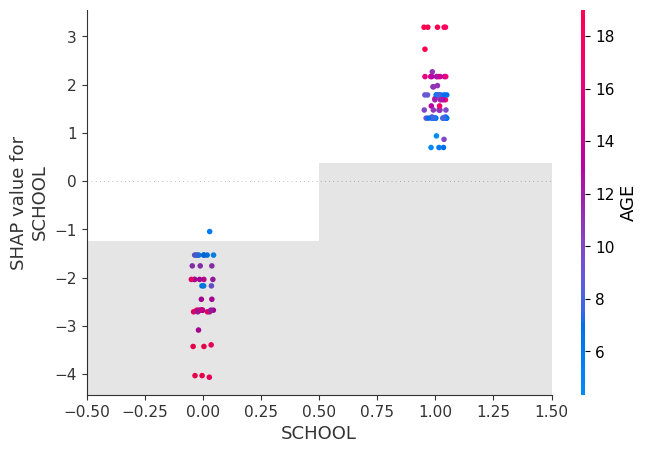

In [19]:
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution

# train XGBoost model
model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

shap.plots.beeswarm(shap_values_xgb)

for i in range(X.shape[1]):
    if 'PRICE':
        pass
    shap.plots.scatter(shap_values_xgb[:,i], color=shap_values_xgb)
    plt.show()